In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Embedding, LSTM, Flatten,
                                     Conv2D, MaxPooling2D, Dropout, concatenate)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import cv2
import matplotlib.pyplot as plt

2025-04-28 16:54:28.243831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745859268.479636      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745859268.549765      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

# Load Text Data (Sentiment140)
text_df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)
text_df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
print("Text Dataset Loaded ✅")

# Load Image Data (FER2013)
# Directory: /kaggle/input/fer2013/train/ and /test/
image_data_dir = '/kaggle/input/fer2013/train'

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']







Text Dataset Loaded ✅


In [3]:
# Preprocess Data
# Select only necessary columns
texts = text_df['text']
labels_text = text_df['target']

# Binary classification: 0 = negative, 4 = positive
labels_text = labels_text.apply(lambda x: 0 if x == 0 else 1)

# Tokenizing
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
text_sequences = tokenizer.texts_to_sequences(texts)
text_padded = pad_sequences(text_sequences, maxlen=100)

print("Text Data Preprocessing Done ✅")


Text Data Preprocessing Done ✅


In [4]:

image_size = 48
image_data = []
image_labels = []

for emotion_idx, emotion_name in enumerate(emotion_labels):
    emotion_folder = os.path.join(image_data_dir, emotion_name)
    for img_file in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size, image_size))
        img = img / 255.0  # Normalize
        image_data.append(img)
        image_labels.append(emotion_idx)

image_data = np.expand_dims(np.array(image_data), -1)  # (N, 48, 48, 1)
image_labels = np.array(image_labels)

print("Image Data Preprocessing Done ")


Image Data Preprocessing Done 


In [5]:
# Step 5: Prepare Combined Dataset
combined_images, combined_texts, combined_labels = [], [], []

for i in range(min(len(image_data), len(text_padded))):
    combined_images.append(image_data[i])
    combined_texts.append(text_padded[i])
    combined_labels.append(image_labels[i])

combined_images = np.array(combined_images)
combined_texts = np.array(combined_texts)
combined_labels = np.array(combined_labels)

# Split into training and testing sets
X_img_train, X_img_test, X_txt_train, X_txt_test, y_train, y_test = train_test_split(
    combined_images, combined_texts, combined_labels, test_size=0.2, random_state=42
)

print("Combined Data Prepared ")


Combined Data Prepared 


In [6]:

# 🏗 Step 6: Build Models


# Text Model
text_input = Input(shape=(100,))
x = Embedding(input_dim=10000, output_dim=128)(text_input)
x = LSTM(64)(x)
text_output = Dense(64, activation='relu')(x)

# Image Model
image_input = Input(shape=(48, 48, 1))
y = Conv2D(32, (3, 3), activation='relu')(image_input)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)
image_output = Dense(64, activation='relu')(y)

# Combine Models
combined = concatenate([text_output, image_output])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(7, activation='softmax')(z)  # 7 emotion classes

model = Model(inputs=[image_input, text_input], outputs=z)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

print("Multi-Modal Model Built")


2025-04-28 16:58:06.221202: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 46, 46, 32)     │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 23, 23, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 21, 21, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 128)       │      1,280,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 10, 10, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         49,408 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 6400)           │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          4,160 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │        409,664 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         16,512 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 7)              │            903 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,779,463 (6.79 MB)

 Trainable params: 1,779,463 (6.79 MB)

 Non-trainable params: 0 (0.00 B)

Multi-Modal Model Built


In [7]:

# Step 7: Train Model


history = model.fit(
    [X_img_train, X_txt_train],
    y_train,
    validation_data=([X_img_test, X_txt_test], y_test),
    epochs=10,
    batch_size=128
)

print("Training Done ")

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 54s 271ms/step - accuracy: 0.2477 - loss: 1.8171 - val_accuracy: 0.3892 - val_loss: 1.5707
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 81s 267ms/step - accuracy: 0.4058 - loss: 1.5400 - val_accuracy: 0.4493 - val_loss: 1.4236
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 83s 274ms/step - accuracy: 0.5153 - loss: 1.3092 - val_accuracy: 0.4502 - val_loss: 1.4155
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 81s 270ms/step - accuracy: 0.6054 - loss: 1.0959 - val_accuracy: 0.4568 - val_loss: 1.4445
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - accuracy: 0.7036 - loss: 0.8671 - val_accuracy: 0.4540 - val_loss: 1.5855
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 49s 270ms/step - accuracy: 0.7661 - loss: 0.6964 - val_accuracy: 0.4131 - val_loss: 1.7996
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 83s 278ms/step - accuracy: 0.8128 - loss: 0.5534 - val_accuracy: 0.4194 - val_loss: 2.0429
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 48s 269ms/step - accuracy: 0.8525 - loss: 0

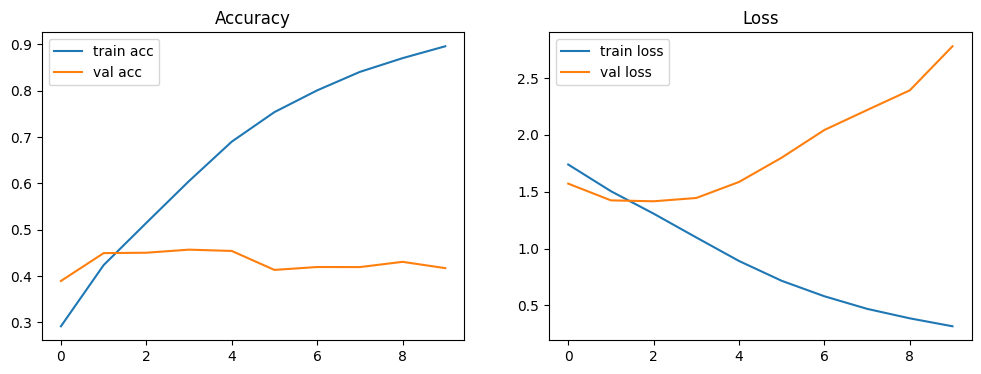

In [8]:

# Step 8: Plot Accuracy and Loss (Optional)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.show()
